# Initialization Schemes for Input Convex Neural Network

As input convex neural networks (ICNN) are notoriously difficult to train ([Richter-Powell et al., 2021](https://arxiv.org/pdf/2111.12187.pdf), [Bunne et al. (2022)](https://arxiv.org/pdf/2206.14262.pdf) propose to use closed-form solutions between Gaussian approximations to derive relevant parameter initializations for ICNNs.
In particular, [Bunne et al. (2022)](https://arxiv.org/pdf/2206.14262.pdf) address the problem of initializing the parameters of ICNNs to ensure their gradient evaluated at every point is (initially) meaningful in the context of OT, namely that it is able to approximately map a measure $\nu$ into a target measure $\nu$. The initializers build heavily on closed-form solutions available for Gaussian approximations of measures ([Gelbrich, 1990](https://onlinelibrary.wiley.com/doi/abs/10.1002/mana.19901470121)).

In this notebook, we briefly introduce the *identity* and *Gaussian approximation*-based initialization schemes and introduce their usability within the `OTT` library and its `ICNN`-based `NeuralDual` module.

import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader
from ott.tools.sinkhorn_divergence import sinkhorn_divergence
from ott.geometry import pointcloud
from ott.core.neuraldual import NeuralDualSolver
from ott.core import icnn

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader
from ott.tools.sinkhorn_divergence import sinkhorn_divergence
from ott.geometry import pointcloud
from ott.core.neuraldual import NeuralDualSolver
from ott.core import icnn

## Helper Functions

Let us define some helper functions which we use for the subsequent analysis.

In [2]:
def plot_ot_map(neural_dual, source, target, inverse=False):
    """Plot data and learned optimal transport map."""

    def draw_arrows(a, b):
        plt.arrow(a[0], a[1], b[0] - a[0], b[1] - a[1],
                  color=[0.5, 0.5, 1], alpha=0.3)

    if not inverse:
      grad_state_s = neural_dual.transport(source)
    else:
      grad_state_s = neural_dual.inverse_transport(source)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(target[:, 0], target[:, 1], color='#A7BED3',
               alpha=0.5, label=r'$target$')
    ax.scatter(source[:, 0], source[:, 1], color='#1A254B',
               alpha=0.5, label=r'$source$')
    if not inverse:
        ax.scatter(grad_state_s[:, 0], grad_state_s[:, 1], color='#F2545B',
               alpha=0.5, label=r'$\nabla g(source)$')
    else:
        ax.scatter(grad_state_s[:, 0], grad_state_s[:, 1], color='#F2545B',
                   alpha=0.5, label=r'$\nabla f(target)$')

    plt.legend()

    for i in range(source.shape[0]):
        draw_arrows(source[i, :], grad_state_s[i, :])

In [3]:
def get_optimizer(optimizer, lr, b1, b2, eps):
  """Returns a flax optimizer object based on `config`."""

  if optimizer == 'Adam':
      optimizer = optax.adam(learning_rate=lr, b1=b1, b2=b2, eps=eps)
  elif optimizer == 'SGD':
      optimizer = optax.sgd(learning_rate=lr, momentum=None, nesterov=False)
  else:
      raise NotImplementedError(
          f'Optimizer {optimizer} not supported yet!')

  return optimizer

In [4]:
@jax.jit
def sinkhorn_loss(x, y, epsilon=0.1, power=2.0):
    """Computes transport between (x, a) and (y, b) via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)

    sdiv = sinkhorn_divergence(pointcloud.PointCloud, x, y, power=power,
                               epsilon=epsilon, a=a, b=b)
    return sdiv.divergence

## Setup Training and Validation Datasets

We apply the `NeuralDual` to compute the transport between toy datasets. In this tutorial, the user can choose between the datasets `simple` (data clustered in one center), `circle` (two-dimensional Gaussians arranged on a circle), `square_five` (two-dimensional Gaussians on a square with one Gaussian in the center), and `square_four` (two-dimensional Gaussians in the corners of a rectangle).

In [5]:
class ToyDataset(IterableDataset):
    def __init__(self, name):
        self.name = name

    def __iter__(self):
        return self.create_sample_generators()

    def create_sample_generators(self, scale=5.0, variance=0.5):
        # given name of dataset, select centers
        if self.name == "simple":
            centers = np.array([0, 0])

        elif self.name == "circle":
            centers = np.array(
                [
                    (1, 0),
                    (-1, 0),
                    (0, 1),
                    (0, -1),
                    (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
                    (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
                    (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
                    (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
                ]
            )

        elif self.name == "square_five":
            centers = np.array([[0, 0], [1, 1], [-1, 1], [-1, -1], [1, -1]])

        elif self.name == "square_four":
            centers = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])

        else:
            raise NotImplementedError()

        # create generator which randomly picks center and adds noise
        centers = scale * centers
        while True:
            center = centers[np.random.choice(len(centers))]
            point = center + variance**2 * np.random.randn(2)

            yield point


def load_toy_data(name_source: str,
                  name_target: str,
                  batch_size: int = 1024,
                  valid_batch_size: int = 1024):
    dataloaders = (
      iter(DataLoader(ToyDataset(name_source), batch_size=batch_size)),
      iter(DataLoader(ToyDataset(name_target), batch_size=batch_size)),
      iter(DataLoader(ToyDataset(name_source), batch_size=valid_batch_size)),
      iter(DataLoader(ToyDataset(name_target), batch_size=valid_batch_size)),
    )
    input_dim = 2
    return dataloaders, input_dim

## Experimental Setup 

In order to solve the neural dual, we need to define our dataloaders. The only requirement is that the corresponding source and target train and validation datasets are *iterators*.

In [6]:
(dataloader_source, dataloader_target, _, _), input_dim = load_toy_data('simple', 'circle')

To visualize the initialization schemes, let's sample data from the source and target distribution.

In [7]:
data_source = next(dataloader_source).numpy()
data_target = next(dataloader_target).numpy()

In [8]:
# initialize optimizers
optimizer_f = get_optimizer('Adam', lr=0.0001, b1=0.5, b2=0.9, eps=0.00000001)
optimizer_g = get_optimizer('Adam', lr=0.0001, b1=0.5, b2=0.9, eps=0.00000001)

### Identity Initialization Method

Next, we define the architectures parameterizing the dual potentials $f$ and $g$. These need to be parameterized by ICNNs. You can adapt the size of the ICNNs by passing a sequence containing hidden layer sizes. While ICNNs are by default containing partially positive weights, we can solve the `NeuralDual` using approximations to this positivity constraint (via weight clipping and a weight penalization). For this, set `positive weights` to True in both the `ICNN` architecture and `NeuralDualSolver` configuration. For more details on how to customize the ICNN architectures, we refer you to the documentation.

We first explore the `identity`-initialization method. This initialization method is the default choice of the current ICNN, thus no further 

In [9]:
# initialize models using identity initialization (default)
neural_f = icnn.ICNN(dim_hidden=[64, 64, 64, 64], dim_data=2)
neural_g = icnn.ICNN(dim_hidden=[64, 64, 64, 64], dim_data=2)

In [10]:
neural_dual_solver = NeuralDualSolver(
    input_dim, neural_f, neural_g, optimizer_f, optimizer_g, num_train_iters=0)
neural_dual = neural_dual_solver(
    dataloader_source, dataloader_target, dataloader_source, dataloader_target)

0it [00:00, ?it/s]

Now, we can plot the corresponding transport from source to target using the gradient of the learning potential `NeuralDual.g`, i.e., $\nabla g(\text{source})$, or from target to source via the gradient of the learning potential `NeuralDual.f`, i.e., $\nabla f(\text{target})$.

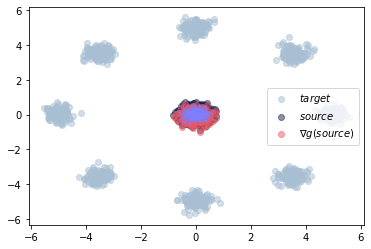

In [11]:
plot_ot_map(neural_dual, data_source, data_target, inverse=False)

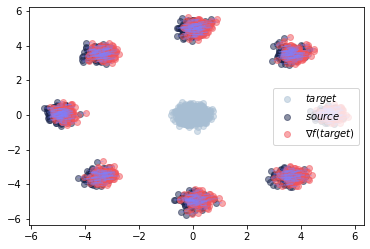

In [12]:
plot_ot_map(neural_dual, data_target, data_source, inverse=True)

Before training, the `identity` initialization (`num_train_iters=0`) maps source or target sample onto itself. If source and target samples are not too dissimilar, this initialization method compared to a random vanilla weight initialization achieves a good approximation already.

### Gaussian Initialization

Let's analyze the Gaussian approximation-based initialization scheme. For this, we in addition need to pass the samples of both, source and target distribution, to the ICNNs such that factors and means can be computed. More details, can be found in [Bunne et al. (2022)](https://arxiv.org/pdf/2206.14262.pdf).

In [13]:
samples_source = jnp.concatenate([next(dataloader_source).numpy() for _ in range(10)])
samples_target = jnp.concatenate([next(dataloader_target).numpy() for _ in range(10)])

To use the Gaussian initialization, the samples of source and target (`samples_source` and `samples_target`) need to be passed to the ICNN definition via the `gaussian_map` argument. Note that ICNN `f` maps target to source (`gaussian_map=(samples_target, samples_source)`), and `g` maps source to target cells (`gaussian_map=(samples_source, samples_target)`).

In [14]:
# initialize models using Gaussian initialization
neural_f = icnn.ICNN(dim_hidden=[64, 64, 64, 64], dim_data=2,
                     gaussian_map=(samples_target, samples_source))
neural_g = icnn.ICNN(dim_hidden=[64, 64, 64, 64], dim_data=2,
                     gaussian_map=(samples_source, samples_target))

In [15]:
neural_dual_solver = NeuralDualSolver(
    input_dim, neural_f, neural_g, optimizer_f, optimizer_g, num_train_iters=0)
neural_dual = neural_dual_solver(
    dataloader_source, dataloader_target, dataloader_source, dataloader_target)

0it [00:00, ?it/s]

Again, we can plot the corresponding transport from source to target using the gradient of the learning potential `NeuralDual.g`, i.e., $\nabla g(\text{source})$, or from target to source via the gradient of the learning potential `NeuralDual.f`, i.e., $\nabla f(\text{target})$.

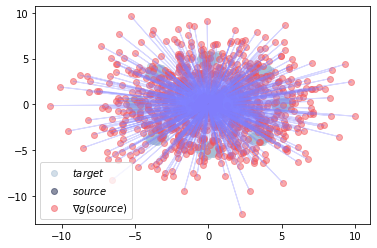

In [16]:
plot_ot_map(neural_dual, data_source, data_target, inverse=False)

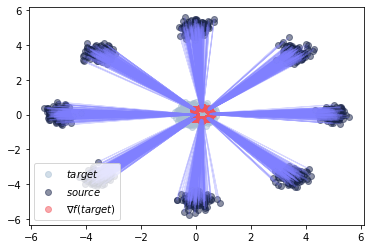

In [17]:
plot_ot_map(neural_dual, data_target, data_source, inverse=True)

Using this initialization scheme maps the source (using `g`) or target measure (using `f`) to the Gaussian approximation of the respective counterpart. In the case of target $\mu$ this represents almost the correct solution.

For more details on the execution of the `NeuralDual` module, we refer the reader to [this](https://ott-jax.readthedocs.io/en/latest/notebooks/neural_dual.html) notebook.